# Accuracy as a function of mag for stars/galaxies

In this notebook we show how the "update" RF model classifies both point sources and extended sources as a function of magnitude.

In [1]:
import sys,os,math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
from matplotlib import gridspec as grs
from matplotlib import cm
from matplotlib.legend import Legend
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from astropy.table import Table
import seaborn as sns
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from numpy import interp



In [2]:
%matplotlib notebook

## Preload the data

In [3]:
hst_tab = Table.read("HST_COSMOS_Forcefeatures_adamamiller.fit").to_pandas()

In [4]:
fnames = ['E1', 'E2', 'FPSFKronDist',
          'FPSFApDist', 'FPSFApRatio',  'FPSFKronRatio',
          'FPSFflxR5Ratio', 'FPSFflxR6Ratio', 'FPSFflxR7Ratio']
fil = 'ww'
features = [fil  + feat for feat in fnames]

In [5]:
classifier = RandomForestClassifier(n_estimators = 900, 
                                    min_samples_leaf = 2, 
                                    max_features= 3, 
                                    n_jobs=-1, 
                                    random_state =  20)

In [6]:
labels_GT = np.array(hst_tab.MU_CLASS - 1, dtype=int)

hst_det_mask = (hst_tab.nDetections > 0)
print("There are {:d} sources in the PS1 subset from HST".format(sum(hst_det_mask)))
hst_GT = labels_GT[hst_det_mask]

There are 47825 sources in the PS1 subset from HST


In [7]:
# get simple model classification threshold

gridsize=100
grid = np.linspace(0.5e-6, 3e-6, gridsize)
acc_arr = np.zeros_like(grid)
for th_num, thrsh in enumerate(grid):
    smpl_labels = np.logical_not(np.array(hst_tab["wwFPSFApDist"].loc[hst_det_mask]) < thrsh).astype(int)
    acc_arr[th_num] = accuracy_score(hst_GT, smpl_labels)
    
print('The optimal threshold for the simple model is: {:.2e}'.format(grid[np.argmax(acc_arr)]))

The optimal threshold for the simple model is: 1.48e-06


In [12]:
def get_CV_preds(hst_tab, hst_det_mask, feats, n_splits=10, rs=23):
    ps1_preds = np.array(hst_tab["iFPSFminusFKron"].loc[hst_det_mask])
    simple_preds = np.array(hst_tab["wwFPSFApDist"].loc[hst_det_mask])
    X_hst = np.array(hst_tab[feats].loc[hst_det_mask])
    y_hst = np.array(hst_tab["MU_CLASS"].loc[hst_det_mask] - 1, dtype=int)
    rf_preds = np.empty_like(simple_preds)
    cv = StratifiedKFold(n_splits=n_splits, random_state=rs)
    for train, test in cv.split(X_hst, y_hst):
        rf_preds[test] = classifier.fit(X_hst[train], 
                                        y_hst[train]).predict_proba(X_hst[test])[:,1]
    return y_hst, ps1_preds, simple_preds, rf_preds

In [13]:
y_hst, ps1_preds, simple_preds, rf_preds = get_CV_preds(hst_tab, hst_det_mask, features, n_splits=10, rs=23)

In [15]:
def calc_fom(fpr, tpr, thresh):
    return interp(0.005, fpr, tpr)

In [16]:
def calc_summary_stats(y_hst, ps1_preds, simple_preds, rf_preds, 
                       ps1_ct = 0.05, 
                       simple_ct = 1.48e-06,
                       rf_ct = 0.5,
                       make_plot = False,
                       fold_plot = True):
    ps1_fpr, ps1_tpr, ps1_thresh = roc_curve(y_hst, -1*ps1_preds)
    ps1_fom = calc_fom(ps1_fpr, ps1_tpr, ps1_thresh)
    ps1_auc = roc_auc_score(y_hst, -1*ps1_preds)
    ps1_acc = accuracy_score(y_hst, ps1_preds <= ps1_ct)
    
    simple_fpr, simple_tpr, simple_thresh = roc_curve(y_hst, simple_preds)
    simple_fom = calc_fom(simple_fpr, simple_tpr, simple_thresh)
    simple_auc = roc_auc_score(y_hst, simple_preds)
    simple_acc = accuracy_score(y_hst, simple_preds >= simple_ct)
    
    rf_fpr, rf_tpr, rf_thresh = roc_curve(y_hst, rf_preds)
    rf_fom = calc_fom(rf_fpr, rf_tpr, rf_thresh)
    rf_auc = roc_auc_score(y_hst, rf_preds)
    rf_acc = accuracy_score(y_hst, rf_preds >= rf_ct)
    
    if make_plot:
        lw = 0.5 if fold_plot else 2
        alpha = 0.4 if fold_plot else 1
        for ax in [main_ax, axins]:
            ax.plot(rf_fpr, rf_tpr, lw=lw, color="#7570b3", alpha=alpha)
            ax.plot(simple_fpr, simple_tpr, lw=lw, color="#1b9e77", alpha=alpha)
            ax.plot(ps1_fpr, ps1_tpr, lw=lw, color="#34495e", alpha=alpha)

    
    return ps1_auc, ps1_acc, ps1_fom, simple_auc, simple_acc, simple_fom, rf_auc, rf_acc, rf_fom

In [17]:
ps1_det_mask = ~np.isnan(hst_tab[hst_det_mask].iFPSFminusFKron)

<IPython.core.display.Javascript object>


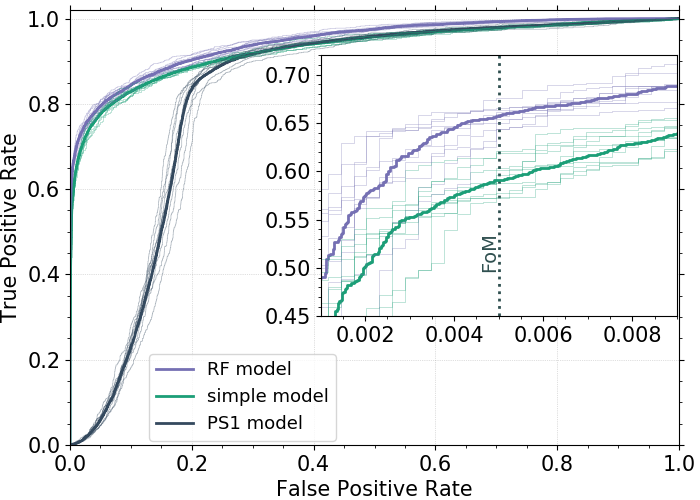

In [47]:
fig, main_ax = plt.subplots(figsize=(7,5))

axins = inset_axes(main_ax, width="58.5%",  
                   height="60%", loc=3,
                   bbox_to_anchor=(0.4, 0.28, 1., 1.),
                   bbox_transform=main_ax.transAxes)


cv = StratifiedKFold(n_splits=10, random_state=23)
X_hst = np.array(hst_tab[features].loc[hst_det_mask])

cv_summary_stats = calc_summary_stats(y_hst[ps1_det_mask], 
                                      ps1_preds[ps1_det_mask], 
                                      simple_preds[ps1_det_mask], 
                                      rf_preds[ps1_det_mask], 
                                      make_plot=True, fold_plot=False)

for fold_num, (train, test) in enumerate(cv.split(X_hst[ps1_det_mask], 
                                                  y_hst[ps1_det_mask])):
    fold_results = calc_summary_stats(y_hst[ps1_det_mask][test], 
                                      ps1_preds[ps1_det_mask][test], 
                                      simple_preds[ps1_det_mask][test], 
                                      rf_preds[ps1_det_mask][test], 
                                      make_plot=True)
    if fold_num == 0:
        each_fold_sum_stats = fold_results
    else:
        each_fold_sum_stats = np.vstack((each_fold_sum_stats, fold_results))



main_ax.set_xlim(0,1) 
main_ax.set_ylim(0,1.02)
main_ax.grid(alpha=0.5, lw=0.5, c='grey', linestyle=':') 
main_ax.tick_params(which="both", top=True, right=True, labelsize = 15)
main_ax.minorticks_on()
main_ax.set_xlabel('False Positive Rate', fontsize=15)
main_ax.set_ylabel('True Positive Rate', fontsize=15)

# legend stuff
main_ax.plot([1e6,1e6], [1e6,1e6], lw=2, 
        color="#7570b3", alpha=1,
        label='RF model')
main_ax.plot([1e6,1e6], [1e6,1e6], lw=2, 
        color="#1b9e77", alpha=1,
        label='simple model')
main_ax.plot([1e6,1e6], [1e6,1e6], lw=2, 
        color="#34495e", alpha=1,
        label='PS1 model')
main_ax.legend(loc=3, borderaxespad=0, fontsize=13,
               bbox_to_anchor=(0.13, 0.01, 1., 0.102), )
# SDSS color = #7570b3

        
# axins.vlines([5e-3], 1e-3, 1, color='grey', lw=0.5)
axins.vlines([5e-3], 1e-3, 1, 
          linestyles=":", 
          color='DarkSlateGrey', lw=2)
axins.text(5e-3, 0.5, 'FoM', 
        color='DarkSlateGrey', 
        rotation=90, ha="right", fontsize=14)

axins.set_xlim(1e-3, 9e-3)
axins.set_ylim(0.45, 0.72)
axins.tick_params(labelsize = 15)
axins.minorticks_on()

fig.subplots_adjust(right=0.97,top=0.98,bottom=0.11,left=0.1)
fig.savefig("../paperII/figures/CV_ROC_FHST.pdf")

In [21]:
print(r"""
RF & {0:.3f} $\pm$ {9:.3f} & {1:.3f} $\pm$ {10:.3f} & {2:.3f} $\pm$ {11:.3f} \\
simple & {3:.3f} $\pm$ {12:.3f} & {4:.3f} $\pm$ {13:.3f} & {5:.3f} $\pm$ {14:.3f} \\
PS1 & {6:.3f} $\pm$ {15:.3f} & {7:.3f} $\pm$ {16:.3f} & {8:.3f} $\pm$ {17:.3f} \\
""".format(*np.append(cv_summary_stats[::-1], np.std(each_fold_sum_stats, ddof=1, axis=0)[::-1])))


RF & 0.657 $\pm$ 0.010 & 0.917 $\pm$ 0.002 & 0.945 $\pm$ 0.003 \\
simple & 0.591 $\pm$ 0.017 & 0.910 $\pm$ 0.003 & 0.930 $\pm$ 0.003 \\
PS1 & 0.002 $\pm$ 0.001 & 0.764 $\pm$ 0.011 & 0.827 $\pm$ 0.009 \\



In [22]:
kron_mag = np.array(-2.5*np.log10(hst_tab['wwFKronFlux'].loc[hst_det_mask]/3631))

binwidth = 0.5
mag_array = np.arange(15 , 23.5+binwidth, binwidth)

In [23]:
ml_labels = rf_preds
simple_decision_thresh = 1.48e-06 #  maximize acc on training set
simple_labels = np.logical_not(np.array(hst_tab["wwFPSFApDist"].loc[hst_det_mask]) < simple_decision_thresh).astype(int)
ps1_labels = np.array(hst_tab["iFPSFminusFKron"].loc[hst_det_mask] < 0.05).astype(int)


## New stuff

Below –– Calculate the accuracy of stars and galaxies in individual mag bins

In [29]:
Nboot = 100


# bootstrap acc arrays
simple_acc_arr = np.zeros_like(mag_array)
ps1_acc_arr = np.zeros_like(mag_array)
ml_acc_arr = np.zeros_like(mag_array)

simple_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))


# bootstrap star arrays
simple_star_acc_arr = np.zeros_like(mag_array)
ml_star_acc_arr = np.zeros_like(mag_array)

simple_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

# bootstrap galaxy arrays
simple_gal_acc_arr = np.zeros_like(mag_array)
ml_gal_acc_arr = np.zeros_like(mag_array)

simple_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

for bin_num, binedge in enumerate(mag_array):
    bin_sources = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                           (np.isfinite(hst_tab["iFPSFminusFKron"].loc[hst_det_mask])))
    simple_acc_arr[bin_num] = accuracy_score(hst_GT[bin_sources], 
                                             simple_labels[bin_sources])
    ps1_acc_arr[bin_num] = accuracy_score(hst_GT[bin_sources], 
                                          ps1_labels[bin_sources])
    ml_acc_arr[bin_num] = accuracy_score(hst_GT[bin_sources], 
                                         np.round(ml_labels[bin_sources]))
    
    ### STARS
    bin_stars = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                         (hst_GT == 1))
    simple_star_acc_arr[bin_num] = accuracy_score(hst_GT[bin_stars], 
                                             simple_labels[bin_stars])
    ml_star_acc_arr[bin_num] = accuracy_score(hst_GT[bin_stars], 
                                         np.round(ml_labels[bin_stars]))
    ### GALAXIES
    bin_gals = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                        (hst_GT == 0))
    simple_gal_acc_arr[bin_num] = accuracy_score(hst_GT[bin_gals], 
                                             simple_labels[bin_gals])
    ml_gal_acc_arr[bin_num] = accuracy_score(hst_GT[bin_gals], 
                                         np.round(ml_labels[bin_gals]))
    
    # get the bootstrap accuracies
    
    simple_boot_acc = np.empty(Nboot)
    ps1_boot_acc = np.empty_like(simple_boot_acc)
    ml_boot_acc = np.empty_like(simple_boot_acc)
    
    simple_star_boot_acc = np.empty_like(simple_boot_acc)
    ml_star_boot_acc = np.empty_like(simple_boot_acc)
    
    simple_gal_boot_acc = np.empty_like(simple_boot_acc)
    ml_gal_boot_acc = np.empty_like(simple_boot_acc)

    for i in range(Nboot):
        boot_sources = np.random.choice(bin_sources[0], len(bin_sources[0]), 
                                             replace=True)
        simple_boot_acc[i] = accuracy_score(hst_GT[boot_sources], 
                                            simple_labels[boot_sources])
        ps1_boot_acc[i] = accuracy_score(hst_GT[boot_sources], 
                                         ps1_labels[boot_sources])
        ml_boot_acc[i] = accuracy_score(hst_GT[boot_sources], 
                                        np.round(ml_labels[boot_sources]))
        
        star_boot_sources = np.random.choice(bin_stars[0], len(bin_stars[0]), 
                                             replace=True)
        simple_star_boot_acc[i] = accuracy_score(hst_GT[star_boot_sources], 
                                             simple_labels[star_boot_sources])
        ml_star_boot_acc[i] = accuracy_score(hst_GT[star_boot_sources], 
                                             np.round(ml_labels[star_boot_sources]))
        
        gal_boot_sources = np.random.choice(bin_gals[0], len(bin_gals[0]), 
                                            replace=True)
        simple_gal_boot_acc[i] = accuracy_score(hst_GT[gal_boot_sources], 
                                             simple_labels[gal_boot_sources])
        ml_gal_boot_acc[i] = accuracy_score(hst_GT[gal_boot_sources], 
                                            np.round(ml_labels[gal_boot_sources]))


    simple_boot_scatt[:,bin_num] = np.percentile(simple_boot_acc, [16, 84])
    ps1_boot_scatt[:,bin_num] = np.percentile(ps1_boot_acc, [16, 84])
    ml_boot_scatt[:,bin_num] = np.percentile(ml_boot_acc, [16, 84])
    
    
    simple_star_boot_scatt[:,bin_num] = np.percentile(simple_star_boot_acc, [16, 84])
    ml_star_boot_scatt[:,bin_num] = np.percentile(ml_star_boot_acc, [16, 84])    
    
    simple_gal_boot_scatt[:,bin_num] = np.percentile(simple_gal_boot_acc, [16, 84])
    ml_gal_boot_scatt[:,bin_num] = np.percentile(ml_gal_boot_acc, [16, 84])

In [31]:
# get the KDEs

star_norm = np.sum(hst_GT==1)/len(hst_GT)
gal_norm = np.sum(hst_GT==0)/len(hst_GT)

All_kde = stats.gaussian_kde(kron_mag)
Star_kde = stats.gaussian_kde(kron_mag[hst_GT==1])
Gal_kde = stats.gaussian_kde(kron_mag[hst_GT==0])
n = (np.arange(12,25,0.01))
All_kde_pdf = All_kde(n)
Star_kde_pdf = Star_kde(n)*star_norm
Gal_kde_pdf = Gal_kde(n)*gal_norm

<IPython.core.display.Javascript object>


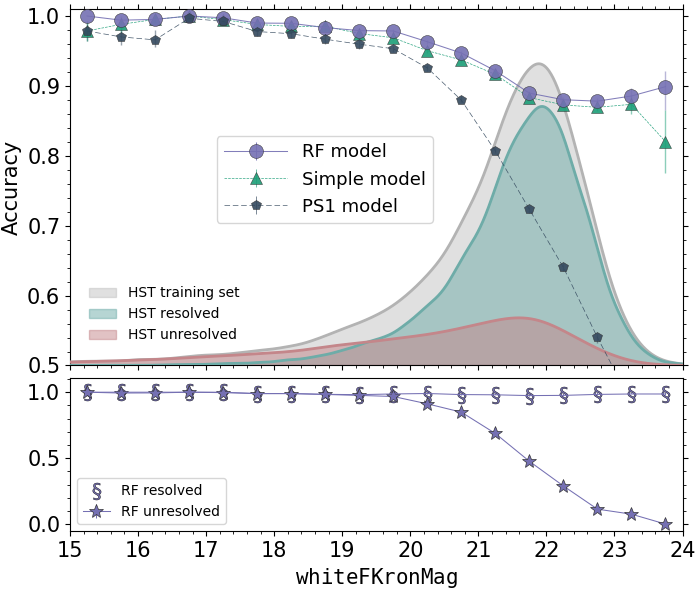

In [48]:
cmap = plt.get_cmap("Dark2")

color_dict = {'ml': cmap(0.33), 
              'sdss': cmap(0.66), 
              'simple': cmap(0.),
              'ps1': cmap(1.)}

color_dict = {'ml': cmap(0.33), 
              'sdss': cmap(0.66), 
              'simple': cmap(0.),
              'ps1': cmap(1.)}

# apple colors
color_dict = {'ml': "#0072c6", #"#1C1858",
              'sdss': "#5BC236", #"#00C78E",
              'simple': "#C864AF", #"#C70039",
              'ps1': "#C65400"}

# color blind friendly
color_dict = {'ml': '#0072b2', 
              'sdss': '#d55e00', 
              'simple': '#cc79a7',
              'ps1': '#009e73'}

# color brewer
color_dict = {'ml': '#7570b3', 
              'sdss': '#d95f02', 
              'simple': '#1b9e77',
              'ps1': '#34495e'}

ls_dict = {'ml': '-', 
              'sdss': '-.', 
              'simple': '--',
              'ps1': '--'}

lw_dict = {'ml': .75, 
              'sdss': .5, 
              'simple': .5, 
              'ps1': .5}

bias = 0.5

cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

mag_bin_centers = mag_array + binwidth/2

fig, (ax, ax_sg) = plt.subplots(2, 1, sharex=True,
                                gridspec_kw={'height_ratios': [7, 3]},
                                figsize=(7,6))

ax.vlines(mag_bin_centers, ps1_boot_scatt[0], ps1_boot_scatt[1], 
           color=color_dict['ps1'], alpha=0.5, linewidth=1, zorder=3)
ax.vlines(mag_bin_centers, simple_boot_scatt[0], simple_boot_scatt[1], 
           color=color_dict['simple'], alpha=0.5, linewidth=1, zorder=4)
ax.vlines(mag_bin_centers, ml_boot_scatt[0], ml_boot_scatt[1], 
           color=color_dict['ml'], alpha=0.5, linewidth=1, zorder=5)
ax.errorbar(mag_bin_centers, ml_acc_arr, color=color_dict['ml'], yerr=np.zeros_like(mag_array), 
            fmt='o', ms=10,  zorder=10, mew=0.4, mec="0.2", alpha=0.9, 
            ls=ls_dict['ml'], lw = lw_dict['ml'], label='RF model')
ax.errorbar(mag_bin_centers, simple_acc_arr, color=color_dict['simple'], yerr=np.zeros_like(mag_array), 
            fmt='^',ms=8, zorder=5, mew=0.4, mec="0.2", alpha=0.9, 
            ls=ls_dict['simple'], lw = lw_dict['simple'],  label='Simple model')
ax.errorbar(mag_bin_centers, ps1_acc_arr, color=color_dict['ps1'], yerr=np.zeros_like(mag_array),  
            fmt='p', ms=7, zorder=25, mew=0.4, mec="0.2", alpha=0.9, 
            ls=ls_dict['ps1'], lw = lw_dict['ps1'], dashes=(8, 4), label='PS1 model')

ax.fill(n, All_kde_pdf + bias, alpha=0.4, color="0.7", zorder=0, label="HST training set")
ax.fill(n, Gal_kde_pdf + bias, alpha=0.5, color=cmap_gal(0.25), zorder=1, label="HST resolved")
ax.fill(n, Star_kde_pdf + bias, alpha=0.5, color=cmap_star(0.25), zorder=2, label="HST unresolved")
ax.plot(n, All_kde_pdf + bias, lw=2, color="0.7", zorder=3)
ax.plot(n, Gal_kde_pdf + bias, lw=2, color=cmap_gal(0.25), zorder=4)
ax.plot(n, Star_kde_pdf + bias, lw=2, color=cmap_star(0.25), zorder=5)

ax.set_ylim(bias,1.01)
ax.set_xlim(15, 24.0)

handles, labels = ax.get_legend_handles_labels()
leg_lines = ax.legend(handles[3:], labels[3:], 
                        bbox_to_anchor=(0.225, 0.375, 1., 0.102),
                        loc=3, fontsize=13, handlelength=3.5)
leg_kde = Legend(ax, handles[:3], labels[:3], 
                  bbox_to_anchor=(0.01, 0.03, 1., 0.102),
                  loc=3,fontsize=10,  frameon=False)
ax.add_artist(leg_kde)

ax.tick_params(labelsize = 15, which="both", top=True,  right=True)
ax.minorticks_on()
ax_sg.set_xlabel('$\mathtt{whiteFKronMag}$', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)

ax_sg.errorbar(mag_bin_centers+0.0, ml_star_acc_arr, 
            yerr=np.abs(ml_star_boot_scatt - ml_star_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt='*', ms=10,
            mec="0.2", mew=0.5,
            color=color_dict['ml'], label="RF unresolved")

# ax_sg.errorbar(mag_bin_centers, simple_star_acc_arr, 
#             yerr=np.abs(simple_star_boot_scatt - simple_star_acc_arr), 
#             ls =ls_dict['simple'], lw=.5, fmt='*', ms=10,
#             mec="0.2", mew=0.5,
#             color=color_dict['simple'], label="Simple model")


ax_sg.scatter(mag_bin_centers-0.0, ml_gal_acc_arr, 
           marker=r'$\S$', s=150, edgecolor='k', linewidths=0.3,
           color=color_dict['ml'], label="RF resolved")
ax_sg.errorbar(mag_bin_centers-0.0, ml_gal_acc_arr, 
            yerr=np.abs(ml_gal_boot_scatt - ml_gal_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt=',',
            color=color_dict['ml'])


# ax_sg.scatter(mag_bin_centers-0.1, simple_gal_acc_arr, 
#            marker=r'$\S$', s=150, edgecolor='k', linewidths=0.3,
#            color=color_dict['simple'], label="simple galaxies")
# ax_sg.errorbar(mag_bin_centers-0.1, simple_gal_acc_arr, 
#             yerr=np.abs(simple_star_boot_scatt - simple_star_acc_arr), 
#             ls =ls_dict['simple'], lw=.75, fmt=',',
#             color=color_dict['simple'])
ax_sg.legend()
ax_sg.tick_params(labelsize = 15, which="both", top=False,  right=True)
ax_sg.minorticks_on()


fig.subplots_adjust(right=0.975,top=0.985,bottom=0.115,left=0.1, hspace=0.05)
fig.savefig("../paperII/figures/CV_Accuracy_FHST.pdf")

In [58]:
def summary_stats_bootstrap(gt, preds, ct=0.5, fom_at=[0.005, 0.01, 0.02, 0.05, 0.1], Nboot=100, mag_max = 30):
    mag_mask = np.where(ap_mag  < mag_max)
    acc = accuracy_score(gt[mag_mask], preds[mag_mask] >= ct)
    auc = roc_auc_score(gt[mag_mask], preds[mag_mask])
    fpr, tpr, thresh = roc_curve(gt[mag_mask], preds[mag_mask])
    fom_thresh = np.array([calc_fom(fpr, tpr, thresh, f) for f in fom_at])
    thresh = fom_thresh[:,0]
    fom = fom_thresh[:,1]
    acc_std_arr = np.empty(Nboot)
    auc_std_arr = np.empty_like(acc_std_arr)
    fom_std_arr = np.empty((Nboot, len(fom_at)))
    thresh_std_arr = np.empty_like(fom_std_arr)
    for i in range(Nboot):
        boot_sources = np.random.choice(mag_mask[0], len(mag_mask[0]), replace=True)
        auc_std_arr[i] = roc_auc_score(gt[boot_sources], preds[boot_sources])
        acc_std_arr[i] = accuracy_score(gt[boot_sources], preds[boot_sources] >= ct)
        _fpr, _tpr, _thresh = roc_curve(gt[boot_sources], preds[boot_sources])
        _fom_thresh = np.array([calc_fom(_fpr, _tpr, _thresh, f) for f in fom_at])
        thresh_std_arr[i,:] = _fom_thresh[:,0]
        fom_std_arr[i,:] = _fom_thresh[:,1]
    #acc = np.percentile(acc_std_arr, [50] ,axis=0)[0]
    #auc = np.percentile(auc_std_arr, [50] ,axis=0)[0]
    #fom = np.percentile(fom_std_arr, [50] ,axis=0)[0]
    #thresh = np.percentile(thresh_std_arr, [50] ,axis=0)[0]
    #acc = np.average(acc_std_arr,axis=0)
    #auc = np.average(auc_std_arr, axis=0)
    #fom = np.average(fom_std_arr, axis=0)
    #thresh = np.average(thresh_std_arr,axis=0)
    acc_std = np.percentile(acc_std_arr, [5, 95] ,axis=0) #np.std(acc_std_arr)
    auc_std = np.percentile(auc_std_arr, [5, 95] ,axis=0) #np.std(auc_std_arr)
    fom_std = np.percentile(fom_std_arr, [5, 95] ,axis=0) #np.std(fom_std_arr, axis=0)
    thresh_std = np.percentile(thresh_std_arr, [16, 95] ,axis=0) #np.std(thresh_std_arr, axis=0)
    return {'Num': len(ap_mag[mag_mask]), 
                'Acc': acc*100, 
                'AUC': auc, 
                'FoM': fom, 
                'Thresh': thresh, 
                'AccSTD': acc_std*100, 
                'AUCSTD': auc_std, 
                'FoMSTD': fom_std, 
                'ThreshSTD': thresh_std}

In [59]:
stat_all = summary_stats_bootstrap(y_hst, rf_preds, Nboot=100)
stat_21 = summary_stats_bootstrap(y_hst, rf_preds, Nboot=100, mag_max=21)
stat_20 = summary_stats_bootstrap(y_hst, rf_preds, Nboot=100, mag_max=20)

In [60]:
stat_all

{'Num': 74759,
 'Acc': 92.31530651827875,
 'AUC': 0.9060297350956561,
 'FoM': array([0.59474142, 0.62834999, 0.66507316, 0.71592061, 0.76575402]),
 'Thresh': array([0.63461512, 0.50816264, 0.38572247, 0.26672665, 0.19296601]),
 'AccSTD': array([92.1585361 , 92.48144036]),
 'AUCSTD': array([0.90316617, 0.90893313]),
 'FoMSTD': array([[0.58706815, 0.62037747, 0.65671256, 0.70897639, 0.76097436],
        [0.60423778, 0.6360672 , 0.67191708, 0.72281897, 0.7729102 ]]),
 'ThreshSTD': array([[0.62326054, 0.50024927, 0.38122742, 0.26480242, 0.19156626],
        [0.65782788, 0.52160776, 0.39193664, 0.27021465, 0.19430528]])}

In [61]:
print('TPR')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_all['FoM'][0], stat_all['FoMSTD'][1][0]-stat_all['FoM'][0], stat_all['FoMSTD'][0][0]-stat_all['FoM'][0], \
            stat_all['FoM'][1], stat_all['FoMSTD'][1][1]-stat_all['FoM'][1], stat_all['FoMSTD'][0][1]-stat_all['FoM'][1], \
            stat_all['FoM'][2], stat_all['FoMSTD'][1][2]-stat_all['FoM'][2], stat_all['FoMSTD'][0][2]-stat_all['FoM'][2], \
            stat_all['FoM'][3], stat_all['FoMSTD'][1][3]-stat_all['FoM'][3], stat_all['FoMSTD'][0][3]-stat_all['FoM'][3], \
            stat_all['FoM'][4], stat_all['FoMSTD'][1][4]-stat_all['FoM'][4], stat_all['FoMSTD'][0][4]-stat_all['FoM'][4]))

print('Threshold')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_all['Thresh'][0], stat_all['ThreshSTD'][1][0]-stat_all['Thresh'][0], stat_all['ThreshSTD'][0][0]-stat_all['Thresh'][0], \
            stat_all['Thresh'][1], stat_all['ThreshSTD'][1][1]-stat_all['Thresh'][1], stat_all['ThreshSTD'][0][1]-stat_all['Thresh'][1], \
            stat_all['Thresh'][2], stat_all['ThreshSTD'][1][2]-stat_all['Thresh'][2], stat_all['ThreshSTD'][0][2]-stat_all['Thresh'][2], \
            stat_all['Thresh'][3], stat_all['ThreshSTD'][1][3]-stat_all['Thresh'][3], stat_all['ThreshSTD'][0][3]-stat_all['Thresh'][3], \
            stat_all['Thresh'][4], stat_all['ThreshSTD'][1][4]-stat_all['Thresh'][4], stat_all['ThreshSTD'][0][4]-stat_all['Thresh'][4]))

TPR
 $0.595^{+0.009}_{-0.008}$ & $0.628^{+0.008}_{-0.008}$ & $0.665^{+0.007}_{-0.008}$ & $0.716^{+0.007}_{-0.007}$ & $0.766^{+0.007}_{-0.005}$ 

Threshold
 $0.635^{+0.023}_{-0.011}$ & $0.508^{+0.013}_{-0.008}$ & $0.386^{+0.006}_{-0.004}$ & $0.267^{+0.003}_{-0.002}$ & $0.193^{+0.001}_{-0.001}$ 



In [62]:
stat_21

{'Num': 14582,
 'Acc': 97.23631874914278,
 'AUC': 0.9934436378057071,
 'FoM': array([0.85990546, 0.94413408, 0.96347228, 0.97622117, 0.98710786]),
 'Thresh': array([0.93918437, 0.72483952, 0.44507716, 0.20174607, 0.11501108]),
 'AccSTD': array([97.04361542, 97.43519407]),
 'AUCSTD': array([0.99265468, 0.99423867]),
 'FoMSTD': array([[0.82182453, 0.93651146, 0.96008269, 0.97343387, 0.98500754],
        [0.90137059, 0.94964999, 0.96867418, 0.97882488, 0.98905685]]),
 'ThreshSTD': array([[0.90038703, 0.68613001, 0.39812365, 0.19626481, 0.11203635],
        [0.9584491 , 0.77431798, 0.49270338, 0.21265946, 0.11816341]])}

In [63]:
print('TPR')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_21['FoM'][0], stat_21['FoMSTD'][1][0]-stat_21['FoM'][0], stat_21['FoMSTD'][0][0]-stat_21['FoM'][0], \
            stat_21['FoM'][1], stat_21['FoMSTD'][1][1]-stat_21['FoM'][1], stat_21['FoMSTD'][0][1]-stat_21['FoM'][1], \
            stat_21['FoM'][2], stat_21['FoMSTD'][1][2]-stat_21['FoM'][2], stat_21['FoMSTD'][0][2]-stat_21['FoM'][2], \
            stat_21['FoM'][3], stat_21['FoMSTD'][1][3]-stat_21['FoM'][3], stat_21['FoMSTD'][0][3]-stat_21['FoM'][3], \
            stat_21['FoM'][4], stat_21['FoMSTD'][1][4]-stat_21['FoM'][4], stat_21['FoMSTD'][0][4]-stat_21['FoM'][4]))

print('Threshold')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_21['Thresh'][0], stat_21['ThreshSTD'][1][0]-stat_21['Thresh'][0], stat_21['ThreshSTD'][0][0]-stat_21['Thresh'][0], \
            stat_21['Thresh'][1], stat_21['ThreshSTD'][1][1]-stat_21['Thresh'][1], stat_21['ThreshSTD'][0][1]-stat_21['Thresh'][1], \
            stat_21['Thresh'][2], stat_21['ThreshSTD'][1][2]-stat_21['Thresh'][2], stat_21['ThreshSTD'][0][2]-stat_21['Thresh'][2], \
            stat_21['Thresh'][3], stat_21['ThreshSTD'][1][3]-stat_21['Thresh'][3], stat_21['ThreshSTD'][0][3]-stat_21['Thresh'][3], \
            stat_21['Thresh'][4], stat_21['ThreshSTD'][1][4]-stat_21['Thresh'][4], stat_21['ThreshSTD'][0][4]-stat_21['Thresh'][4]))

TPR
 $0.860^{+0.041}_{-0.038}$ & $0.944^{+0.006}_{-0.008}$ & $0.963^{+0.005}_{-0.003}$ & $0.976^{+0.003}_{-0.003}$ & $0.987^{+0.002}_{-0.002}$ 

Threshold
 $0.939^{+0.019}_{-0.039}$ & $0.725^{+0.049}_{-0.039}$ & $0.445^{+0.048}_{-0.047}$ & $0.202^{+0.011}_{-0.005}$ & $0.115^{+0.003}_{-0.003}$ 



In [64]:
stat_20

{'Num': 6966,
 'Acc': 98.92334194659776,
 'AUC': 0.997169793030594,
 'FoM': array([0.87592475, 0.94800254, 0.99260199, 0.99661805, 0.99873177]),
 'Thresh': array([0.98112202, 0.94242044, 0.34598439, 0.15509251, 0.06595062]),
 'AccSTD': array([98.73600345, 99.153029  ]),
 'AUCSTD': array([0.99599911, 0.99838242]),
 'FoMSTD': array([[0.7594698 , 0.91391203, 0.99010002, 0.99467426, 0.99784686],
        [0.94185533, 0.9917045 , 0.99542584, 0.99788295, 0.99938145]]),
 'ThreshSTD': array([[0.9606859 , 0.66418035, 0.29743491, 0.14346216, 0.06094126],
        [0.9933023 , 0.96794446, 0.49454752, 0.18708543, 0.07831343]])}

In [65]:
print('TPR')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_20['FoM'][0], stat_20['FoMSTD'][1][0]-stat_20['FoM'][0], stat_20['FoMSTD'][0][0]-stat_20['FoM'][0], \
            stat_20['FoM'][1], stat_20['FoMSTD'][1][1]-stat_20['FoM'][1], stat_20['FoMSTD'][0][1]-stat_20['FoM'][1], \
            stat_20['FoM'][2], stat_20['FoMSTD'][1][2]-stat_20['FoM'][2], stat_20['FoMSTD'][0][2]-stat_20['FoM'][2], \
            stat_20['FoM'][3], stat_20['FoMSTD'][1][3]-stat_20['FoM'][3], stat_20['FoMSTD'][0][3]-stat_20['FoM'][3], \
            stat_20['FoM'][4], stat_20['FoMSTD'][1][4]-stat_20['FoM'][4], stat_20['FoMSTD'][0][4]-stat_20['FoM'][4]))

print('Threshold')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$  
"""%(stat_20['Thresh'][0], stat_20['ThreshSTD'][1][0]-stat_20['Thresh'][0], stat_20['ThreshSTD'][0][0]-stat_20['Thresh'][0], \
            stat_20['Thresh'][1], stat_20['ThreshSTD'][1][1]-stat_20['Thresh'][1], stat_20['ThreshSTD'][0][1]-stat_20['Thresh'][1], \
            stat_20['Thresh'][2], stat_20['ThreshSTD'][1][2]-stat_20['Thresh'][2], stat_20['ThreshSTD'][0][2]-stat_20['Thresh'][2], \
            stat_20['Thresh'][3], stat_20['ThreshSTD'][1][3]-stat_20['Thresh'][3], stat_20['ThreshSTD'][0][3]-stat_20['Thresh'][3], \
            stat_20['Thresh'][4], stat_20['ThreshSTD'][1][4]-stat_20['Thresh'][4], stat_20['ThreshSTD'][0][4]-stat_20['Thresh'][4]))

TPR
 $0.876^{+0.066}_{-0.116}$ & $0.948^{+0.044}_{-0.034}$ & $0.993^{+0.003}_{-0.003}$ & $0.997^{+0.001}_{-0.002}$ & $0.999^{+0.001}_{-0.001}$ 

Threshold
 $0.981^{+0.012}_{-0.020}$ & $0.942^{+0.026}_{-0.278}$ & $0.346^{+0.149}_{-0.049}$ & $0.155^{+0.032}_{-0.012}$ & $0.066^{+0.012}_{-0.005}$  

